In [1]:
import os
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

data_dir = "/kaggle/input/new-data/new_dataset"
commercial_dir = os.path.join(data_dir, "commercial")
non_commercial_dir = os.path.join(data_dir, "non_commercial")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [2]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()

        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        self.features = nn.Sequential(*list(model.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

custom_resnet = CustomResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_resnet.parameters(), lr=0.001, momentum=0.9)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 268MB/s]


In [3]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    custom_resnet.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = custom_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    custom_resnet.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = custom_resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Accuracy: {val_accuracies[-1]}")

Epoch 1/10, Train Loss: 0.6835193157196044, Val Loss: 0.654514916241169, Train Accuracy: 56.030150753768844, Val Accuracy: 72.68722466960352
Epoch 2/10, Train Loss: 0.6162739872932435, Val Loss: 0.5884867385029793, Train Accuracy: 73.24120603015075, Val Accuracy: 77.97356828193833
Epoch 3/10, Train Loss: 0.5528659915924072, Val Loss: 0.5307792872190475, Train Accuracy: 81.15577889447236, Val Accuracy: 83.25991189427313
Epoch 4/10, Train Loss: 0.5065458846092225, Val Loss: 0.48204895481467247, Train Accuracy: 82.1608040201005, Val Accuracy: 83.70044052863436
Epoch 5/10, Train Loss: 0.46290539622306826, Val Loss: 0.44338271766901016, Train Accuracy: 81.78391959798995, Val Accuracy: 84.14096916299559
Epoch 6/10, Train Loss: 0.42195823431015017, Val Loss: 0.40788939595222473, Train Accuracy: 83.29145728643216, Val Accuracy: 85.46255506607929
Epoch 7/10, Train Loss: 0.3893865239620209, Val Loss: 0.40087585523724556, Train Accuracy: 84.79899497487438, Val Accuracy: 83.70044052863436
Epoch 8/

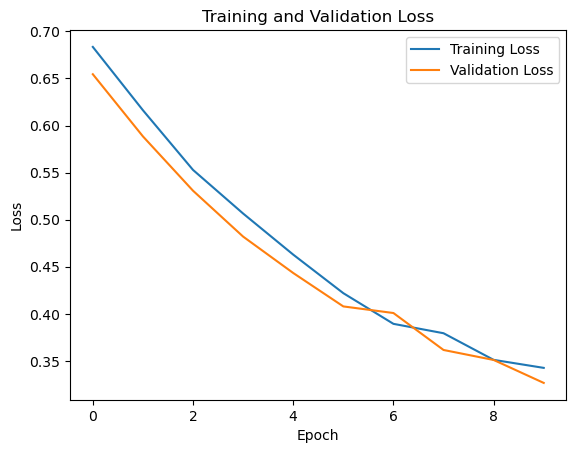

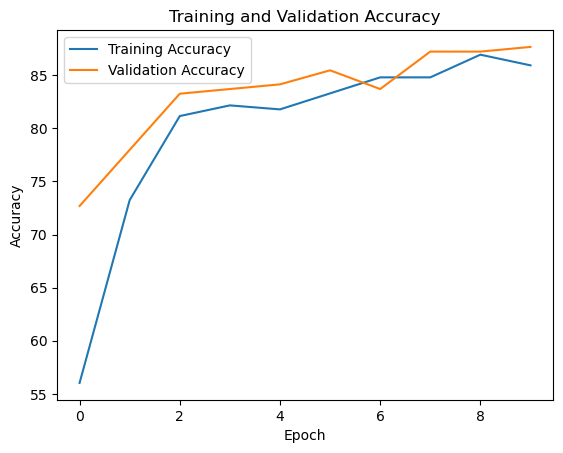

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import precision_recall_fscore_support

custom_resnet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = custom_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.8936
Recall: 0.8235
F1 Score: 0.8571


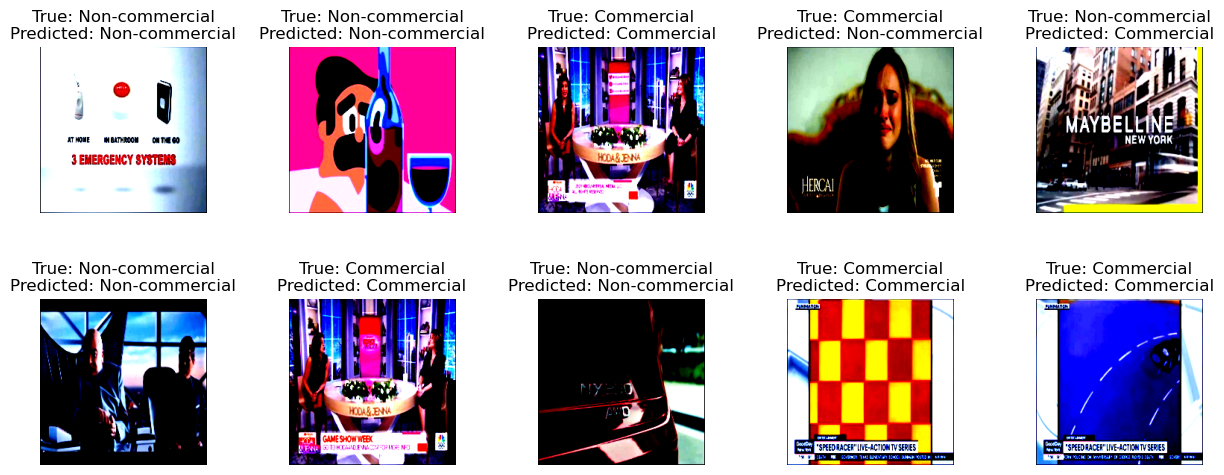

In [6]:
import random
import matplotlib.pyplot as plt


random_indices = random.sample(range(len(test_data)), 10)

# Visualize the frames with their true and predicted labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    image, label = test_data[idx]
    image_tensor = image.unsqueeze(0).to(device)
    output = custom_resnet(image_tensor)
    _, predicted = torch.max(output.data, 1)
    predicted_label = 'Commercial' if predicted.item() == 1 else 'Non-commercial'
    true_label = 'Commercial' if label == 1 else 'Non-commercial'

    axes[i].imshow(image.permute(1, 2, 0).numpy())
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()